In [ ]:
# https://developpaper.com/using-detectron2-to-detect-targets-in-6-steps/
# https://colab.research.google.com/drive/1-TNOcPm3Jr3fOJG8rnGT9gh60mHUsvaW#scrollTo=B4UESNQ4tyVm
# Json format to train detectron2: https://stackoverflow.com/a/63607875/6118987

In [ ]:
# !pip install --user 'git+https://github.com/facebookresearch/fvcore'

# Configs

In [1]:
models = {
    'rpn_r50_fpn': {
        'model_path': 'COCO-Detection/rpn_R_50_FPN_1x.yaml'
    },
    'faster_rcnn_50': {
        'model_path': 'COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml'
    },
    'faster_rcnn_101': {
        'model_path': 'COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml'
    },
    'retinanet': {
        'model_path': 'COCO-Detection/retinanet_R_101_FPN_3x.yaml'
    }
}

# Uncomment the model you would like to use
# MODEL_USE = 'rpn_r50_fpn'
# MODEL_USE = 'faster_rcnn_50'
# MODEL_USE = 'faster_rcnn_101'
MODEL_USE = 'rpn_r50_fpn'

# Load the model config and its pre-trained weights
MODEL_PATH = models[MODEL_USE]['model_path']



#### cfg dict keys :  
    dict_keys(['VERSION', 'MODEL', 'INPUT', 'DATASETS', 'DATALOADER', 'SOLVER', 'TEST',  -->
    'OUTPUT_DIR', 'SEED', 'CUDNN_BENCHMARK', 'VIS_PERIOD', 'GLOBAL'])

#### cfg['MODEL'].keys()

    dict_keys(['LOAD_PROPOSALS', 'MASK_ON', 'KEYPOINT_ON', 'DEVICE', 'META_ARCHITECTURE', 'WEIGHTS', 'PIXEL_MEAN', 
    'PIXEL_STD', 'BACKBONE', 'FPN', 'PROPOSAL_GENERATOR', 'ANCHOR_GENERATOR', 'RPN', 'ROI_HEADS', 'ROI_BOX_HEAD', 
    'ROI_BOX_CASCADE_HEAD', 'ROI_MASK_HEAD', 'ROI_KEYPOINT_HEAD', 'SEM_SEG_HEAD', 'PANOPTIC_FPN', 'RETINANET', 'RESNETS'])
    
#### cfg['MODEL']['ROI_HEADS']

    {'BATCH_SIZE_PER_IMAGE': 512,
     'IN_FEATURES': ['res4'],
     'IOU_LABELS': [0, 1],
     'IOU_THRESHOLDS': [0.5],
     'NAME': 'Res5ROIHeads',
     'NMS_THRESH_TEST': 0.5,
     'NUM_CLASSES': 80,
     'POSITIVE_FRACTION': 0.25,
     'PROPOSAL_APPEND_GT': True,
     'SCORE_THRESH_TEST': 0.05}
    
    
#### cfg['MODEL']['RETINANET']
    {'BBOX_REG_WEIGHTS': (1.0, 1.0, 1.0, 1.0),
     'FOCAL_LOSS_ALPHA': 0.25,
     'FOCAL_LOSS_GAMMA': 2.0,
     'IN_FEATURES': ['p3', 'p4', 'p5', 'p6', 'p7'],
     'IOU_LABELS': [0, -1, 1],
     'IOU_THRESHOLDS': [0.4, 0.5],
     'NMS_THRESH_TEST': 0.5,
     'NUM_CLASSES': 80,
     'NUM_CONVS': 4,
     'PRIOR_PROB': 0.01,
     'SCORE_THRESH_TEST': 0.05,
     'SMOOTH_L1_LOSS_BETA': 0.1,
     'TOPK_CANDIDATES_TEST': 1000}
    
#### cfg['SOLVER']
    {'BASE_LR': 0.001,
     'BIAS_LR_FACTOR': 1.0,
     'CHECKPOINT_PERIOD': 5000,
     'CLIP_GRADIENTS': {'CLIP_TYPE': 'value',
                        'CLIP_VALUE': 1.0,
                        'ENABLED': False,
                        'NORM_TYPE': 2.0},
     'GAMMA': 0.1,
     'IMS_PER_BATCH': 16,
     'LR_SCHEDULER_NAME': 'WarmupMultiStepLR',
     'MAX_ITER': 40000,
     'MOMENTUM': 0.9,
     'NESTEROV': False,
     'STEPS': (30000,),
     'WARMUP_FACTOR': 0.001,
     'WARMUP_ITERS': 1000,
     'WARMUP_METHOD': 'linear',
     'WEIGHT_DECAY': 0.0001,
     'WEIGHT_DECAY_BIAS': 0.0001,
     'WEIGHT_DECAY_NORM': 0.0}
    
- 'BASE_LR' - base learning rate
- 'IMS_PER_BATCH' - Number of images per batch across all machines. If we have 16 GPUs and IMS_PER_BATCH = 32, each GPU will see 2 images per batch.

In [2]:
import copy
import detectron2
import torch
from detectron2.utils.logger import setup_logger
setup_logger()

import os
import cv2
import json
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.modeling import build_model
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.checkpoint import DetectionCheckpointer

from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_train_loader, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator
from detectron2.data import DatasetMapper

from detectron2.data import transforms as T
from detectron2.data.transforms import TransformGen
from fvcore.transforms.transform import TransformList, Transform, NoOpTransform

import albumentations as A
import copy
import torch
from detectron2.data import detection_utils as utils

import contextlib
import copy
import io
import itertools
import json
import logging
import numpy as np
import os
import pickle
from collections import OrderedDict
import pycocotools.mask as mask_util
import torch
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from tabulate import tabulate

import detectron2.utils.comm as comm
from detectron2.config import CfgNode
from detectron2.data import MetadataCatalog
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2.evaluation.fast_eval_api import COCOeval_opt
from detectron2.structures import Boxes, BoxMode, pairwise_iou
from detectron2.utils.file_io import PathManager
from detectron2.utils.logger import create_small_table

import numpy as np
import logging

from detectron2.engine.hooks import HookBase
from detectron2.utils.logger import log_every_n_seconds
import detectron2.utils.comm as comm
import torch
import time
import datetime

# Register the dataset

In [3]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("train", {}, "./train.json", ".")
register_coco_instances("val", {}, "./test.json", ".")

In [ ]:
# !rm -r dataset/

In [ ]:
# !python convert2coco.py

In [4]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("train")
dataset_dicts = DatasetCatalog.get("train")
import random
# from detectron2.utils.visualizer import Visualizer
# for d in random.sample(dataset_dicts, 3):
#     img = cv2.imread(d["file_name"])
# #     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     visualizer = Visualizer(img, metadata=my_dataset_train_metadata, scale=0.5)
#     vis = visualizer.draw_dataset_dict(d)
#     plt.imshow(vis.get_image())
#     plt.show()

[07/21 11:26:59 d2.data.datasets.coco]: Loaded 1484 images in COCO format from ./train.json


# Data Augmentation

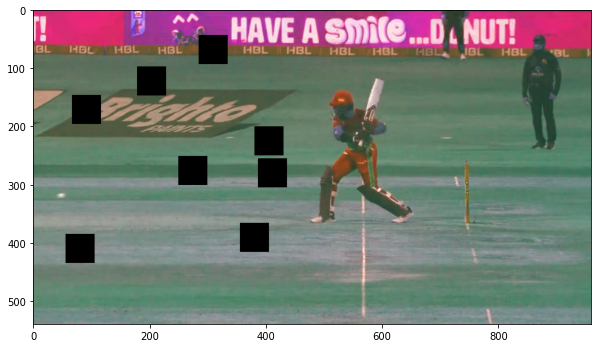

In [5]:
from detectron2.data import transforms as T
from detectron2.data.transforms import TransformGen
from fvcore.transforms.transform import TransformList, Transform, NoOpTransform

class CutMix(Transform):
    def __init__(self, box_size=50, prob_cutmix=0.5):
        super().__init__()

        self.box_size = box_size
        self.prob_cutmix = prob_cutmix

    def apply_image(self, img):

        if random.random() < self.prob_cutmix:

            h, w = img.shape[:2]
            num_rand = np.random.randint(10, 20)
            for num_cut in range(num_rand):
                x_rand = random.randint(0, w - self.box_size)
                y_rand = random.randint(0, h - self.box_size)
                img[x_rand: x_rand + self.box_size, y_rand: y_rand + self.box_size, :] = 0

        return np.asarray(img)

    def apply_coords(self, coords):
        return coords.astype(np.float32)


img = CutMix(prob_cutmix=1.).apply_image(cv2.imread(dataset_dicts[0]['file_name']))
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

In [7]:
# def strong_aug(image, all_p=0.5, flip_p=0.5, blur_p=0.5, distort_p=.0, iaa_p=.0, brightness_p=.0, noise_p=.0, color_p=0.0):
#     aug = Compose([
#         aug_flip(p=flip_p), 
#         aug_distortion(p=distort_p),
#         aug_iaa(p=iaa_p),
#         # aug_nature(p=nature_p),
#         aug_brightness(p=brightness_p),
#         aug_noise(p=noise_p),
#         aug_blur(p=blur_p),
#         # aug_color(p=color_p)
#     ], 
#         p=all_p)
#     result = aug(image=image)
#     return result['image']

In [6]:
import albumentations as A
import copy
import numpy as np
import torch
from detectron2.data import detection_utils as utils


class AlbumentationsMapper:
    """Mapper which uses `albumentations` augmentations"""
    def __init__(self, cfg, is_train: bool = True):
#         aug_kwargs = cfg.aug_kwargs
        aug_list = []
        if is_train:
            aug_list = [
                A.Flip(),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5)
            ]
        # aug_list.extend([getattr(A, name)(**kwargs) for name, kwargs in aug_kwargs.items()])
        self.transform = A.Compose(aug_list, bbox_params=A.BboxParams(format="pascal_voc", label_fields=["category_ids"]))
        self.is_train = is_train

        mode = "training" if is_train else "inference"
        print(f"[AlbumentationsMapper] Augmentations used in {mode}: {self.transform}")

    def __call__(self, dataset_dict):
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        image = utils.read_image(dataset_dict["file_name"], format="BGR")

        prev_anno = dataset_dict["annotations"]
        bboxes = np.array([obj["bbox"] for obj in prev_anno], dtype=np.float32)
        category_id = np.arange(len(dataset_dict["annotations"]))

        transformed = self.transform(image=image, bboxes=bboxes, category_ids=category_id)
        image = transformed["image"]
        annos = []
        for i, j in enumerate(transformed["category_ids"]):
            d = prev_anno[j]
            d["bbox"] = transformed["bboxes"][i]
            annos.append(d)
        dataset_dict.pop("annotations", None)  # Remove unnecessary field.

        image_shape = image.shape[:2]  # h, w
        dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
        instances = utils.annotations_to_instances(annos, image_shape)
        dataset_dict["instances"] = utils.filter_empty_instances(instances)
        return dataset_dict

In [7]:
"""
Original code from https://github.com/cocodataset/cocoapi/blob/8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9/PythonAPI/pycocotools/cocoeval.py
Just modified to show AP@40
"""
# Copyright (c) Facebook, Inc. and its affiliates.

def vin_summarize(self):
    '''
    Compute and display summary metrics for evaluation results.
    Note this functin can *only* be applied on the default parameter setting
    '''

    def _summarize(ap=1, iouThr=None, areaRng='all', maxDets=100):
        p = self.params
        iStr = ' {:<18} {} @[ IoU={:<9} | area={:>6s} | maxDets={:>3d} ] = {:0.3f}'
        titleStr = 'Average Precision' if ap == 1 else 'Average Recall'
        typeStr = '(AP)' if ap == 1 else '(AR)'
        iouStr = '{:0.2f}:{:0.2f}'.format(p.iouThrs[0], p.iouThrs[-1]) \
            if iouThr is None else '{:0.2f}'.format(iouThr)

        aind = [i for i, aRng in enumerate(p.areaRngLbl) if aRng == areaRng]
        mind = [i for i, mDet in enumerate(p.maxDets) if mDet == maxDets]
        if ap == 1:
            # dimension of precision: [TxRxKxAxM]
            s = self.eval['precision']
            # IoU
            if iouThr is not None:
                t = np.where(iouThr == p.iouThrs)[0]
                s = s[t]
            s = s[:, :, :, aind, mind]
        else:
            # dimension of recall: [TxKxAxM]
            s = self.eval['recall']
            if iouThr is not None:
                t = np.where(iouThr == p.iouThrs)[0]
                s = s[t]
            s = s[:, :, aind, mind]
        if len(s[s > -1]) == 0:
            mean_s = -1
        else:
            mean_s = np.mean(s[s > -1])
        print(iStr.format(titleStr, typeStr, iouStr, areaRng, maxDets, mean_s))
        return mean_s

    def _summarizeDets():
        stats = np.zeros((12,))
        stats[0] = _summarize(1)
        stats[1] = _summarize(1, iouThr=.5, maxDets=self.params.maxDets[2])
        stats[2] = _summarize(1, iouThr=.75, maxDets=self.params.maxDets[2])
        stats[3] = _summarize(1, iouThr=.9, maxDets=self.params.maxDets[2])
        stats[4] = _summarize(1, areaRng='small', maxDets=self.params.maxDets[2])
        stats[5] = _summarize(1, areaRng='medium', maxDets=self.params.maxDets[2])
        stats[6] = _summarize(1, areaRng='large', maxDets=self.params.maxDets[2])
        stats[7] = _summarize(0, maxDets=self.params.maxDets[0])
        stats[8] = _summarize(0, maxDets=self.params.maxDets[1])
        stats[9] = _summarize(0, maxDets=self.params.maxDets[2])
        stats[10] = _summarize(0, areaRng='small', maxDets=self.params.maxDets[2])
        stats[11] = _summarize(0, areaRng='medium', maxDets=self.params.maxDets[2])
        stats[12] = _summarize(0, areaRng='large', maxDets=self.params.maxDets[2])
        return stats

    def _summarizeKps():
        stats = np.zeros((10,))
        stats[0] = _summarize(1, maxDets=20)
        stats[1] = _summarize(1, maxDets=20, iouThr=.5)
        stats[2] = _summarize(1, maxDets=20, iouThr=.75)
        stats[3] = _summarize(1, maxDets=20, areaRng='medium')
        stats[4] = _summarize(1, maxDets=20, areaRng='large')
        stats[5] = _summarize(0, maxDets=20)
        stats[6] = _summarize(0, maxDets=20, iouThr=.5)
        stats[7] = _summarize(0, maxDets=20, iouThr=.75)
        stats[8] = _summarize(0, maxDets=20, areaRng='medium')
        stats[9] = _summarize(0, maxDets=20, areaRng='large')
        return stats

    if not self.eval:
        raise Exception('Please run accumulate() first')
    iouType = self.params.iouType
    if iouType == 'segm' or iouType == 'bbox':
        summarize = _summarizeDets
    elif iouType == 'keypoints':
        summarize = _summarizeKps
    self.stats = summarize()


print("HACKING: overriding COCOeval.summarize = vin_summarize...")
COCOeval.summarize = vin_summarize


class BalldataEvaluator(DatasetEvaluator):
    """
    Evaluate AR for object proposals, AP for instance detection/segmentation, AP
    for keypoint detection outputs using COCO's metrics.
    See http://cocodataset.org/#detection-eval and
    http://cocodataset.org/#keypoints-eval to understand its metrics.

    In addition to COCO, this evaluator is able to support any bounding box detection,
    instance segmentation, or keypoint detection dataset.
    """

    def __init__(
        self,
        dataset_name,
        tasks=None,
        distributed=True,
        output_dir=None,
        *,
        use_fast_impl=True,
        kpt_oks_sigmas=(),
    ):
        """
        Args:
            dataset_name (str): name of the dataset to be evaluated.
                It must have either the following corresponding metadata:

                    "json_file": the path to the COCO format annotation

                Or it must be in detectron2's standard dataset format
                so it can be converted to COCO format automatically.
            tasks (tuple[str]): tasks that can be evaluated under the given
                configuration. A task is one of "bbox", "segm", "keypoints".
                By default, will infer this automatically from predictions.
            distributed (True): if True, will collect results from all ranks and run evaluation
                in the main process.
                Otherwise, will only evaluate the results in the current process.
            output_dir (str): optional, an output directory to dump all
                results predicted on the dataset. The dump contains two files:

                1. "instances_predictions.pth" a file in torch serialization
                   format that contains all the raw original predictions.
                2. "coco_instances_results.json" a json file in COCO's result
                   format.
            use_fast_impl (bool): use a fast but **unofficial** implementation to compute AP.
                Although the results should be very close to the official implementation in COCO
                API, it is still recommended to compute results with the official API for use in
                papers. The faster implementation also uses more RAM.
            kpt_oks_sigmas (list[float]): The sigmas used to calculate keypoint OKS.
                See http://cocodataset.org/#keypoints-eval
                When empty, it will use the defaults in COCO.
                Otherwise it should be the same length as ROI_KEYPOINT_HEAD.NUM_KEYPOINTS.
        """
        self._logger = logging.getLogger(__name__)
        self._distributed = distributed
        self._output_dir = output_dir
        self._use_fast_impl = use_fast_impl

        if tasks is not None and isinstance(tasks, CfgNode):
            kpt_oks_sigmas = (
                tasks.TEST.KEYPOINT_OKS_SIGMAS if not kpt_oks_sigmas else kpt_oks_sigmas
            )
            self._logger.warn(
                "COCO Evaluator instantiated using config, this is deprecated behavior."
                " Please pass in explicit arguments instead."
            )
            self._tasks = None  # Infering it from predictions should be better
        else:
            self._tasks = tasks

        self._cpu_device = torch.device("cpu")

        self._metadata = MetadataCatalog.get(dataset_name)
        if not hasattr(self._metadata, "json_file"):
            self._logger.info(
                f"'{dataset_name}' is not registered by `register_coco_instances`."
                " Therefore trying to convert it to COCO format ..."
            )

            cache_path = os.path.join(output_dir, f"{dataset_name}_coco_format.json")
            self._metadata.json_file = cache_path
            convert_to_coco_json(dataset_name, cache_path)

        json_file = PathManager.get_local_path(self._metadata.json_file)
        with contextlib.redirect_stdout(io.StringIO()):
            self._coco_api = COCO(json_file)

        # Test set json files do not contain annotations (evaluation must be
        # performed using the COCO evaluation server).
        self._do_evaluation = "annotations" in self._coco_api.dataset
        if self._do_evaluation:
            self._kpt_oks_sigmas = kpt_oks_sigmas

    def reset(self):
        self._predictions = []

    def process(self, inputs, outputs):
        """
        Args:
            inputs: the inputs to a COCO model (e.g., GeneralizedRCNN).
                It is a list of dict. Each dict corresponds to an image and
                contains keys like "height", "width", "file_name", "image_id".
            outputs: the outputs of a COCO model. It is a list of dicts with key
                "instances" that contains :class:`Instances`.
        """
        for input, output in zip(inputs, outputs):
            prediction = {"image_id": input["image_id"]}

            if "instances" in output:
                instances = output["instances"].to(self._cpu_device)
                prediction["instances"] = instances_to_coco_json(instances, input["image_id"])
            if "proposals" in output:
                prediction["proposals"] = output["proposals"].to(self._cpu_device)
            if len(prediction) > 1:
                self._predictions.append(prediction)

    def evaluate(self, img_ids=None):
        """
        Args:
            img_ids: a list of image IDs to evaluate on. Default to None for the whole dataset
        """
        if self._distributed:
            comm.synchronize()
            predictions = comm.gather(self._predictions, dst=0)
            predictions = list(itertools.chain(*predictions))

            if not comm.is_main_process():
                return {}
        else:
            predictions = self._predictions

        if len(predictions) == 0:
            self._logger.warning("[VinbigdataEvaluator] Did not receive valid predictions.")
            return {}

        if self._output_dir:
            PathManager.mkdirs(self._output_dir)
            file_path = os.path.join(self._output_dir, "instances_predictions.pth")
            with PathManager.open(file_path, "wb") as f:
                torch.save(predictions, f)

        self._results = OrderedDict()
        if "proposals" in predictions[0]:
            self._eval_box_proposals(predictions)
        if "instances" in predictions[0]:
            self._eval_predictions(predictions, img_ids=img_ids)
        # Copy so the caller can do whatever with results
        return copy.deepcopy(self._results)

    def _tasks_from_predictions(self, predictions):
        """
        Get COCO API "tasks" (i.e. iou_type) from COCO-format predictions.
        """
        tasks = {"bbox"}
        for pred in predictions:
            if "segmentation" in pred:
                tasks.add("segm")
            if "keypoints" in pred:
                tasks.add("keypoints")
        return sorted(tasks)

    def _eval_predictions(self, predictions, img_ids=None):
        """
        Evaluate predictions. Fill self._results with the metrics of the tasks.
        """
        self._logger.info("Preparing results for COCO format ...")
        coco_results = list(itertools.chain(*[x["instances"] for x in predictions]))
        tasks = self._tasks or self._tasks_from_predictions(coco_results)

        # unmap the category ids for COCO
        if hasattr(self._metadata, "thing_dataset_id_to_contiguous_id"):
            dataset_id_to_contiguous_id = self._metadata.thing_dataset_id_to_contiguous_id
            all_contiguous_ids = list(dataset_id_to_contiguous_id.values())
            num_classes = len(all_contiguous_ids)
            assert min(all_contiguous_ids) == 0 and max(all_contiguous_ids) == num_classes - 1

            reverse_id_mapping = {v: k for k, v in dataset_id_to_contiguous_id.items()}
            for result in coco_results:
                category_id = result["category_id"]
                assert category_id < num_classes, (
                    f"A prediction has class={category_id}, "
                    f"but the dataset only has {num_classes} classes and "
                    f"predicted class id should be in [0, {num_classes - 1}]."
                )
                result["category_id"] = reverse_id_mapping[category_id]

        if self._output_dir:
            file_path = os.path.join(self._output_dir, "coco_instances_results.json")
            self._logger.info("Saving results to {}".format(file_path))
            with PathManager.open(file_path, "w") as f:
                f.write(json.dumps(coco_results))
                f.flush()

        if not self._do_evaluation:
            self._logger.info("Annotations are not available for evaluation.")
            return

        self._logger.info(
            "Evaluating predictions with {} COCO API...".format(
                "unofficial" if self._use_fast_impl else "official"
            )
        )
        for task in sorted(tasks):
            coco_eval = (
                _evaluate_predictions_on_coco(
                    self._coco_api,
                    coco_results,
                    task,
                    kpt_oks_sigmas=self._kpt_oks_sigmas,
                    use_fast_impl=self._use_fast_impl,
                    img_ids=img_ids,
                )
                if len(coco_results) > 0
                else None  # cocoapi does not handle empty results very well
            )

            res = self._derive_coco_results(
                coco_eval, task, class_names=self._metadata.get("thing_classes")
            )
            self._results[task] = res

    def _eval_box_proposals(self, predictions):
        """
        Evaluate the box proposals in predictions.
        Fill self._results with the metrics for "box_proposals" task.
        """
        if self._output_dir:
            # Saving generated box proposals to file.
            # Predicted box_proposals are in XYXY_ABS mode.
            bbox_mode = BoxMode.XYXY_ABS.value
            ids, boxes, objectness_logits = [], [], []
            for prediction in predictions:
                ids.append(prediction["image_id"])
                boxes.append(prediction["proposals"].proposal_boxes.tensor.numpy())
                objectness_logits.append(prediction["proposals"].objectness_logits.numpy())

            proposal_data = {
                "boxes": boxes,
                "objectness_logits": objectness_logits,
                "ids": ids,
                "bbox_mode": bbox_mode,
            }
            with PathManager.open(os.path.join(self._output_dir, "box_proposals.pkl"), "wb") as f:
                pickle.dump(proposal_data, f)

        if not self._do_evaluation:
            self._logger.info("Annotations are not available for evaluation.")
            return

        self._logger.info("Evaluating bbox proposals ...")
        res = {}
        areas = {"all": "", "small": "s", "medium": "m", "large": "l"}
        for limit in [100, 1000]:
            for area, suffix in areas.items():
                stats = _evaluate_box_proposals(predictions, self._coco_api, area=area, limit=limit)
                key = "AR{}@{:d}".format(suffix, limit)
                res[key] = float(stats["ar"].item() * 100)
        self._logger.info("Proposal metrics: \n" + create_small_table(res))
        self._results["box_proposals"] = res

    def _derive_coco_results(self, coco_eval, iou_type, class_names=None):
        """
        Derive the desired score numbers from summarized COCOeval.

        Args:
            coco_eval (None or COCOEval): None represents no predictions from model.
            iou_type (str):
            class_names (None or list[str]): if provided, will use it to predict
                per-category AP.

        Returns:
            a dict of {metric name: score}
        """

        metrics = {
            "bbox": ["AP", "AP50", "AP75", "APs", "APm", "APl"],
            "segm": ["AP", "AP50", "AP75", "APs", "APm", "APl"],
            "keypoints": ["AP", "AP50", "AP75", "APm", "APl"],
        }[iou_type]

        if coco_eval is None:
            self._logger.warn("No predictions from the model!")
            return {metric: float("nan") for metric in metrics}

        # the standard metrics
        results = {
            metric: float(coco_eval.stats[idx] * 100 if coco_eval.stats[idx] >= 0 else "nan")
            for idx, metric in enumerate(metrics)
        }
        self._logger.info(
            "Evaluation results for {}: \n".format(iou_type) + create_small_table(results)
        )
        if not np.isfinite(sum(results.values())):
            self._logger.info("Some metrics cannot be computed and is shown as NaN.")

        if class_names is None or len(class_names) <= 1:
            return results
        # Compute per-category AP
        # from https://github.com/facebookresearch/Detectron/blob/a6a835f5b8208c45d0dce217ce9bbda915f44df7/detectron/datasets/json_dataset_evaluator.py#L222-L252 # noqa
        precisions = coco_eval.eval["precision"]
        # precision has dims (iou, recall, cls, area range, max dets)
        assert len(class_names) == precisions.shape[2]

        results_per_category = []
        for idx, name in enumerate(class_names):
            # area range index 0: all area ranges
            # max dets index -1: typically 100 per image
            precision = precisions[:, :, idx, 0, -1]
            precision = precision[precision > -1]
            ap = np.mean(precision) if precision.size else float("nan")
            results_per_category.append(("{}".format(name), float(ap * 100)))

        # tabulate it
        N_COLS = min(6, len(results_per_category) * 2)
        results_flatten = list(itertools.chain(*results_per_category))
        results_2d = itertools.zip_longest(*[results_flatten[i::N_COLS] for i in range(N_COLS)])
        table = tabulate(
            results_2d,
            tablefmt="pipe",
            floatfmt=".3f",
            headers=["category", "AP"] * (N_COLS // 2),
            numalign="left",
        )
        self._logger.info("Per-category {} AP: \n".format(iou_type) + table)

        results.update({"AP-" + name: ap for name, ap in results_per_category})
        return results


def instances_to_coco_json(instances, img_id):
    """
    Dump an "Instances" object to a COCO-format json that's used for evaluation.

    Args:
        instances (Instances):
        img_id (int): the image id

    Returns:
        list[dict]: list of json annotations in COCO format.
    """
    num_instance = len(instances)
    if num_instance == 0:
        return []

    boxes = instances.pred_boxes.tensor.numpy()
    boxes = BoxMode.convert(boxes, BoxMode.XYXY_ABS, BoxMode.XYWH_ABS)
    boxes = boxes.tolist()
    scores = instances.scores.tolist()
    classes = instances.pred_classes.tolist()

    has_mask = instances.has("pred_masks")
    if has_mask:
        # use RLE to encode the masks, because they are too large and takes memory
        # since this evaluator stores outputs of the entire dataset
        rles = [
            mask_util.encode(np.array(mask[:, :, None], order="F", dtype="uint8"))[0]
            for mask in instances.pred_masks
        ]
        for rle in rles:
            # "counts" is an array encoded by mask_util as a byte-stream. Python3's
            # json writer which always produces strings cannot serialize a bytestream
            # unless you decode it. Thankfully, utf-8 works out (which is also what
            # the pycocotools/_mask.pyx does).
            rle["counts"] = rle["counts"].decode("utf-8")

    has_keypoints = instances.has("pred_keypoints")
    if has_keypoints:
        keypoints = instances.pred_keypoints

    results = []
    for k in range(num_instance):
        result = {
            "image_id": img_id,
            "category_id": classes[k],
            "bbox": boxes[k],
            "score": scores[k],
        }
        if has_mask:
            result["segmentation"] = rles[k]
        if has_keypoints:
            # In COCO annotations,
            # keypoints coordinates are pixel indices.
            # However our predictions are floating point coordinates.
            # Therefore we subtract 0.5 to be consistent with the annotation format.
            # This is the inverse of data loading logic in `datasets/coco.py`.
            keypoints[k][:, :2] -= 0.5
            result["keypoints"] = keypoints[k].flatten().tolist()
        results.append(result)
    return results


# inspired from Detectron:
# https://github.com/facebookresearch/Detectron/blob/a6a835f5b8208c45d0dce217ce9bbda915f44df7/detectron/datasets/json_dataset_evaluator.py#L255 # noqa
def _evaluate_box_proposals(dataset_predictions, coco_api, thresholds=None, area="all", limit=None):
    """
    Evaluate detection proposal recall metrics. This function is a much
    faster alternative to the official COCO API recall evaluation code. However,
    it produces slightly different results.
    """
    # Record max overlap value for each gt box
    # Return vector of overlap values
    areas = {
        "all": 0,
        "small": 1,
        "medium": 2,
        "large": 3,
        "96-128": 4,
        "128-256": 5,
        "256-512": 6,
        "512-inf": 7,
    }
    area_ranges = [
        [0 ** 2, 1e5 ** 2],  # all
        [0 ** 2, 32 ** 2],  # small
        [32 ** 2, 96 ** 2],  # medium
        [96 ** 2, 1e5 ** 2],  # large
        [96 ** 2, 128 ** 2],  # 96-128
        [128 ** 2, 256 ** 2],  # 128-256
        [256 ** 2, 512 ** 2],  # 256-512
        [512 ** 2, 1e5 ** 2],
    ]  # 512-inf
    assert area in areas, "Unknown area range: {}".format(area)
    area_range = area_ranges[areas[area]]
    gt_overlaps = []
    num_pos = 0

    for prediction_dict in dataset_predictions:
        predictions = prediction_dict["proposals"]

        # sort predictions in descending order
        # TODO maybe remove this and make it explicit in the documentation
        inds = predictions.objectness_logits.sort(descending=True)[1]
        predictions = predictions[inds]

        ann_ids = coco_api.getAnnIds(imgIds=prediction_dict["image_id"])
        anno = coco_api.loadAnns(ann_ids)
        gt_boxes = [
            BoxMode.convert(obj["bbox"], BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
            for obj in anno
            if obj["iscrowd"] == 0
        ]
        gt_boxes = torch.as_tensor(gt_boxes).reshape(-1, 4)  # guard against no boxes
        gt_boxes = Boxes(gt_boxes)
        gt_areas = torch.as_tensor([obj["area"] for obj in anno if obj["iscrowd"] == 0])

        if len(gt_boxes) == 0 or len(predictions) == 0:
            continue

        valid_gt_inds = (gt_areas >= area_range[0]) & (gt_areas <= area_range[1])
        gt_boxes = gt_boxes[valid_gt_inds]

        num_pos += len(gt_boxes)

        if len(gt_boxes) == 0:
            continue

        if limit is not None and len(predictions) > limit:
            predictions = predictions[:limit]

        overlaps = pairwise_iou(predictions.proposal_boxes, gt_boxes)

        _gt_overlaps = torch.zeros(len(gt_boxes))
        for j in range(min(len(predictions), len(gt_boxes))):
            # find which proposal box maximally covers each gt box
            # and get the iou amount of coverage for each gt box
            max_overlaps, argmax_overlaps = overlaps.max(dim=0)

            # find which gt box is 'best' covered (i.e. 'best' = most iou)
            gt_ovr, gt_ind = max_overlaps.max(dim=0)
            assert gt_ovr >= 0
            # find the proposal box that covers the best covered gt box
            box_ind = argmax_overlaps[gt_ind]
            # record the iou coverage of this gt box
            _gt_overlaps[j] = overlaps[box_ind, gt_ind]
            assert _gt_overlaps[j] == gt_ovr
            # mark the proposal box and the gt box as used
            overlaps[box_ind, :] = -1
            overlaps[:, gt_ind] = -1

        # append recorded iou coverage level
        gt_overlaps.append(_gt_overlaps)
    gt_overlaps = (
        torch.cat(gt_overlaps, dim=0) if len(gt_overlaps) else torch.zeros(0, dtype=torch.float32)
    )
    gt_overlaps, _ = torch.sort(gt_overlaps)

    if thresholds is None:
        step = 0.05
        # thresholds = torch.arange(0.5, 0.95 + 1e-5, step, dtype=torch.float32)
        thresholds = torch.arange(0.4, 0.95 + 1e-5, step, dtype=torch.float32)
    recalls = torch.zeros_like(thresholds)
    # compute recall for each iou threshold
    for i, t in enumerate(thresholds):
        recalls[i] = (gt_overlaps >= t).float().sum() / float(num_pos)
    # ar = 2 * np.trapz(recalls, thresholds)
    ar = recalls.mean()
    return {
        "ar": ar,
        "recalls": recalls,
        "thresholds": thresholds,
        "gt_overlaps": gt_overlaps,
        "num_pos": num_pos,
    }


def _evaluate_predictions_on_coco(
    coco_gt, coco_results, iou_type, kpt_oks_sigmas=None, use_fast_impl=True, img_ids=None
):
    """
    Evaluate the coco results using COCOEval API.
    """
    assert len(coco_results) > 0

    if iou_type == "segm":
        coco_results = copy.deepcopy(coco_results)
        # When evaluating mask AP, if the results contain bbox, cocoapi will
        # use the box area as the area of the instance, instead of the mask area.
        # This leads to a different definition of small/medium/large.
        # We remove the bbox field to let mask AP use mask area.
        for c in coco_results:
            c.pop("bbox", None)

    coco_dt = coco_gt.loadRes(coco_results)
    coco_eval = (COCOeval_opt if use_fast_impl else COCOeval)(coco_gt, coco_dt, iou_type)

    # HACKING: overwrite iouThrs to calc ious 0.4
    coco_eval.params.iouThrs = np.linspace(
        .4, 0.95, int(np.round((0.95 - .4) / .05)) + 1, endpoint=True)

    if img_ids is not None:
        coco_eval.params.imgIds = img_ids

    if iou_type == "keypoints":
        # Use the COCO default keypoint OKS sigmas unless overrides are specified
        if kpt_oks_sigmas:
            assert hasattr(coco_eval.params, "kpt_oks_sigmas"), "pycocotools is too old!"
            coco_eval.params.kpt_oks_sigmas = np.array(kpt_oks_sigmas)
        # COCOAPI requires every detection and every gt to have keypoints, so
        # we just take the first entry from both
        num_keypoints_dt = len(coco_results[0]["keypoints"]) // 3
        num_keypoints_gt = len(next(iter(coco_gt.anns.values()))["keypoints"]) // 3
        num_keypoints_oks = len(coco_eval.params.kpt_oks_sigmas)
        assert num_keypoints_oks == num_keypoints_dt == num_keypoints_gt, (
            f"[VinbigdataEvaluator] Prediction contain {num_keypoints_dt} keypoints. "
            f"Ground truth contains {num_keypoints_gt} keypoints. "
            f"The length of cfg.TEST.KEYPOINT_OKS_SIGMAS is {num_keypoints_oks}. "
            "They have to agree with each other. For meaning of OKS, please refer to "
            "http://cocodataset.org/#keypoints-eval."
        )

    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return coco_eval


HACKING: overriding COCOeval.summarize = vin_summarize...


In [8]:
"""
To calculate & record validation loss

Original code from https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
by @apofeniaco
"""
import numpy as np
import logging

from detectron2.engine.hooks import HookBase
from detectron2.utils.logger import log_every_n_seconds
import detectron2.utils.comm as comm
import torch
import time
import datetime


class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader

    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)

        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        # self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        # return losses
        return mean_loss

    def _get_loss(self, data):
        # How loss is calculated on train_loop
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced

    def after_step(self):
        next_iter = int(self.trainer.iter) + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            mean_loss = self._do_loss_eval()
            self.trainer.storage.put_scalars(validation_loss=mean_loss)
            print("validation do loss eval", mean_loss)
        else:
            pass
            # self.trainer.storage.put_scalars(timetest=11)


In [9]:
class MasoudTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg, sampler=None):
        return build_detection_train_loader(
            cfg, mapper=AlbumentationsMapper(cfg, True), sampler=sampler
        )

    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(
            cfg, dataset_name, mapper=AlbumentationsMapper(cfg, False)
        )

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        # return PascalVOCDetectionEvaluator(dataset_name)  # not working
        # return COCOEvaluator(dataset_name, ("bbox",), False, output_dir=output_folder)
        return BalldataEvaluator(dataset_name, ("bbox",), False, output_dir=output_folder)

    def build_hooks(self):
        hooks = super(MasoudTrainer, self).build_hooks()
        cfg = self.cfg
        if len(cfg.DATASETS.TEST) > 0:
            loss_eval_hook = LossEvalHook(
                cfg.TEST.EVAL_PERIOD,
                self.model,
                MasoudTrainer.build_test_loader(cfg, cfg.DATASETS.TEST[0]),
            )
            hooks.insert(-1, loss_eval_hook)

        return hooks

In [30]:
# aug_kwargs={'HorizontalFlip': {'p': 0.5}, 
#             'VerticalFlip': {'p': 0.5},
#             'ShiftScaleRotate': {'scale_limit': 0.15, 'rotate_limit': 10, 'p': 0.5}, 
#             'RandomBrightnessContrast': {'p': 0.5}}

In [10]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config.config import CfgNode as CN
from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
# cfg.aug_kwargs = CN(aug_kwargs)  # pass aug_kwargs to cfg
cfg.merge_from_file(model_zoo.get_config_file(MODEL_PATH))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ("val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL_PATH)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0001

cfg.SOLVER.WARMUP_ITERS = 500
cfg.SOLVER.MAX_ITER = 5000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = [] # (1000, 1500)
# cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.TEST.EVAL_PERIOD = 100


In [11]:
rm -r output/

In [12]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MasoudTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[07/21 11:28:01 d2.engine.defaults]: Model:
ProposalNetwork(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[07/21 11:28:01 d2.engine.train_loop]: Starting training from iteration 0


/mnt/disk1/environments/detect2_cuda11.3/lib/python3.7/site-packages/torch/_tensor.py:557: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:461.)
  return torch.floor_divide(self, other)
/mnt/disk1/environments/detect2_cuda11.3/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1301.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[07/21 11:28:06 d2.utils.events]:  eta: 0:12:14  iter: 19  total_loss: 0.1027  loss_rpn_cls: 0.09149  loss_rpn_loc: 0.01113  time: 0.1480  data_time: 0.0148  lr: 3.8962e-06  max_mem: 2179M
[07/21 11:28:09 d2.utils.events]:  eta: 0:12:12  iter: 39  total_loss: 0.08599  loss_rpn_cls: 0.07607  loss_rpn_loc: 0.00982  time: 0.1481  data_time: 0.0048  lr: 7.8922e-06  max_mem: 2179M
[07/21 11:28:12 d2.utils.events]:  eta: 0:12:10  iter: 59  total_loss: 0.08886  loss_rpn_cls: 0.0788  loss_rpn_loc: 0.007882  time: 0.1485  data_time: 0.0050  lr: 1.1888e-05  max_mem: 2179M
[07/21 11:28:15 d2.utils.events]:  eta: 0:12:07  iter: 79  total_loss: 0.1048  loss_rpn_cls: 0.09202  loss_rpn_loc: 0.01034  time: 0.1485  data_time: 0.0051  lr: 1.5884e-05  max_mem: 2179M
[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, ad

KeyboardInterrupt: 

# Test the Trained Model

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob
lst = []


cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")
test_images =  glob.glob('test_images/*.jp*g')

for d in test_images:    
    im = cv2.imread(d)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    lst.append(v)
    plt.imshow(v.get_image())
    plt.show()

In [ ]:
# !rm -r dataset/ train.json test.json

In [ ]:
!python convert2coco.py